# 4 实现GPT并生成文本

## 4.1 实现一个LLM结构

LLM总体框架图如下：
1. 词嵌入
2. 多头注意力
3. 输出层

![1718247386638](../image/从零开始构建LLM/1718247386638.png)

In [1]:
# GPT-2 parameter
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

> 根据下图，一步一步编写GPT模型

![1718258629553](../image/从零开始构建LLM/1718258629553.png)

In [2]:
import torch
import torch.nn as nn

编写代码如下所示，但是并没有编写归一化与具体的Transformer块，仅从宏观进行构建，并没有实现细节，甚至某些结构也未声明。

GPT模型架构主要包含：
1. token编码
2. 位置编码
3. transformer块
4. 激活函数
5. dropout
6. 归一化

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
  
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
  
    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5) -> None:
        super().__init__()
  
    def forward(self, x):
        return x

> GPT工作时，数据流向如下

![1718262314570](../image/从零开始构建LLM/1718262314570.png)

In [4]:
import tiktoken

这一部分从宏观上展示了GPT运行时的数据输入与输出
1. 文本编码
2. 组成batch
3. 送入GPT模型
4. 得到输出

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(">> batch: ", batch)

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(">> out shape: ", logits.shape)
print(">> out: ", logits)

>> batch:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
>> out shape:  torch.Size([2, 4, 50257])
>> out:  tensor([[[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [ 0.0497,  0.3861, -0.3281,  ..., -0.1826,  1.3084,  0.9867],
         [ 0.7005,  1.4747, -0.4149,  ...,  1.7756, -0.2280,  0.5384],
         [ 0.4885,  1.7545, -0.6707,  ...,  1.1501, -0.1143, -0.9368]],

        [[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [-0.5591,  0.5797, -0.1296,  ...,  0.2691,  0.3151,  1.4046],
         [ 0.8524,  1.2833, -0.1786,  ..., -0.1982,  0.1097,  0.2812],
         [-0.0190, -0.8277,  0.2299,  ...,  1.7974, -0.1646, -0.1049]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 使用layer normalization进行归一化激活

> 由于梯度消失或爆炸等问题，训练多层深度神经网络有时会具有挑战性。这些问题导致了不稳定的训练动态，使网络难以有效地调整其权值，这意味着学习过程很难为神经网络找到一组参数（权值），以最小化损失函数。换句话说，该网络很难学习数据中的潜在模式，其程度将使其能够做出准确的预测或决策。</br>

> 层归一化背后的主要思想是调整神经网络层的激活（输出），使其均值为0，方差为1，也称为单位方差。这种调整加速了收敛到有效的权重，并确保了一致、可靠的训练。</br>

> **层归一化通常在多头注意模块前后和最终输出层之前应用。**

In [6]:
# torch.set_printoptions(sci_mode=True)  # set float number

class LayerNorm(nn.Module):
    def __init__(self, emb_dim) -> None:
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
  
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

## 4.3 使用层归一化实现前向神经网络


**GeLU**激活函数

在神经网络中，使用最广泛的是ReLU函数，但是在LLM，除了ReLU外，还有两种显著的激活函数：GELU (Gaussian Error Linear Unit) 和 SwiGLU (Sigmoid-Weighted Linear Unit)。GELU和SwiGLU分别是更复杂和光滑的包含高斯单元和s型门控线性单位的激活函数。他们可以表现的更好。

$$
\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$$

In [7]:
class GELU(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * ( 1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [8]:
import matplotlib.pyplot as plt

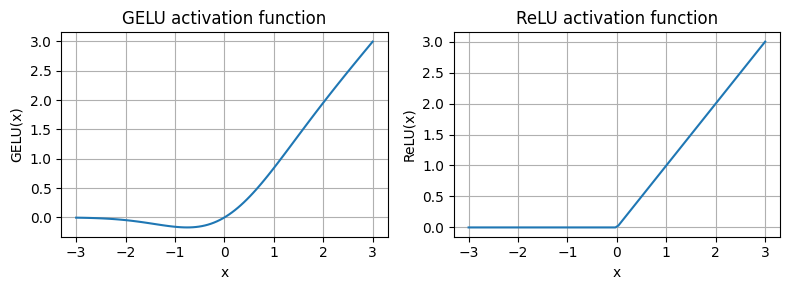

In [9]:
# GELU Test
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', "ReLU"])):
    plt.subplot(1, 2, i+1)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel('x')
    plt.ylabel(f"{label}(x)")
    plt.grid()
plt.tight_layout()

> 在此基础上实现一个前馈网络，这个前馈网络至关重要，主要解决非线性问题，并且可以探索更丰富的空间。

In [10]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layer(x)

In [11]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(">> ffn out size: ", out.shape)

>> ffn out size:  torch.Size([2, 3, 768])


## 4.4 增加短连接

short connection通过跳过一个或多个层来创建一个梯度通过网络的更短路径，这是通过将一个层的输出添加到后面一个层的输出来实现的。这就是为什么这些连接也被称为跳过连接。在训练过程中，它们在保持梯度的流动方面起着至关重要的作用。
（ResNet结构与原理）

![1718273582034](../image/从零开始构建LLM/1718273582034.png)

In [12]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut) -> None:
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [13]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f">> {name} has gradient mean of {param.grad.abs()}")


layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

In [14]:
model_without_shorcut = ExampleDeepNeuralNetwork(layer_sizes, False)
print_gradients(model_without_shorcut, sample_input)

>> layers.0.0.weight has gradient mean of tensor([[0.0018, 0.0000, 0.0018],
        [0.0010, 0.0000, 0.0010],
        [0.0065, 0.0000, 0.0065]])
>> layers.1.0.weight has gradient mean of tensor([[6.3482e-07, 3.8762e-07, 7.6243e-06],
        [1.5987e-04, 9.7618e-05, 1.9201e-03],
        [8.4790e-05, 5.1773e-05, 1.0183e-03]])
>> layers.2.0.weight has gradient mean of tensor([[0.0039, 0.0031, 0.0015],
        [0.0041, 0.0033, 0.0015],
        [0.0050, 0.0040, 0.0019]])
>> layers.3.0.weight has gradient mean of tensor([[0.0491, 0.0031, 0.0283],
        [0.0257, 0.0016, 0.0148],
        [0.0465, 0.0029, 0.0268]])
>> layers.4.0.weight has gradient mean of tensor([[0.0417, 0.0856, 0.0110]])


In [15]:
model_without_shorcut = ExampleDeepNeuralNetwork(layer_sizes, True)
print_gradients(model_without_shorcut, sample_input)

>> layers.0.0.weight has gradient mean of tensor([[3.2044e-06, 0.0000e+00, 3.2044e-06],
        [1.8830e-03, 0.0000e+00, 1.8830e-03],
        [3.0898e-03, 0.0000e+00, 3.0898e-03]])
>> layers.1.0.weight has gradient mean of tensor([[1.5119e-04, 1.8919e-05, 1.4878e-04],
        [8.6263e-04, 1.0795e-04, 8.4891e-04],
        [2.0144e-04, 2.5207e-05, 1.9824e-04]])
>> layers.2.0.weight has gradient mean of tensor([[2.1789e-04, 6.5373e-06, 2.5559e-04],
        [1.2170e-03, 3.6514e-05, 1.4276e-03],
        [4.6673e-05, 1.4003e-06, 5.4749e-05]])
>> layers.3.0.weight has gradient mean of tensor([[1.8056e-04, 2.5326e-05, 2.2459e-04],
        [3.3904e-03, 4.7555e-04, 4.2170e-03],
        [1.9221e-03, 2.6960e-04, 2.3907e-03]])
>> layers.4.0.weight has gradient mean of tensor([[0.0184, 0.0108, 0.0193]])


## 4.5 连接注意力层和线性层

接下来到了核心部分，通过下图方式构建神经网络，其中多头注意力在第三章已经实现

**transformer block的说明**

![1718347509428](../image/从零开始构建LLM/1718347509428.png)

In [16]:
from scripts.GPTmodel import MultiHeadAttention

In [17]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg) -> None:
        super().__init__()
        self.att = MultiHeadAttention(d_in=cfg["emb_dim"], 
                                      d_out=cfg["emb_dim"],
                                      context_length=cfg["context_length"], 
                                      num_heads=cfg["n_heads"],
                                      dropout=cfg["drop_rate"],
                                      qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x

        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut
        return x

## 4.6 编码GPT模型

更进一步，将上述所有模块组装成为一个完整的GPT模型。

![1718352064601](../image/从零开始构建LLM/1718352064601.png)

In [18]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [19]:
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print(">> input batch: ", batch)
print(">> output shape: ", out.shape)
print(">> out: ", out)

>> input batch:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
>> output shape:  torch.Size([2, 4, 50257])
>> out:  tensor([[[ 0.2159,  1.7803, -1.3144,  ...,  0.1518,  0.3433, -0.2426],
         [-0.4640,  0.0124, -0.0818,  ...,  0.1752,  0.8148,  0.2054],
         [-0.3823,  0.1988,  0.2054,  ...,  0.0659, -0.1415,  0.1057],
         [-0.1542,  0.7591, -0.2797,  ..., -0.2908,  0.6896, -0.1746]],

        [[-0.2024,  1.6316, -0.9047,  ...,  0.1310,  0.5152, -0.3395],
         [-0.0648,  0.8608, -0.4911,  ...,  0.5268, -0.0134,  0.3010],
         [-0.1856, -0.6939,  0.0868,  ...,  0.5741, -0.0706,  0.2637],
         [-0.0827, -0.1011,  0.4543,  ...,  0.1231, -0.1420,  0.0325]]],
       grad_fn=<UnsafeViewBackward0>)


接下来查看模型参数量

In [20]:
total_params = sum(p.numel() for p in model.parameters())
print(f">> total number of parameters: {total_params}")

>> total number of parameters: 163009536


> 之前提到代码参数工1.24亿，但是为何这里输出为1.63亿呢？<br/>
其原因是在原始的GPT-2体系结构中使用了一个称为**权重绑定**的概念，这意味着原始的GPT-2体系结构在其输出层中重用了来自标记嵌入层的权重。为了理解这意味着什么，来看看我们之前通过GPTModel在模型上初始化的令牌嵌入层和线性输出层的形状：

In [21]:
print(f">> Token embedding layer shape: {model.tok_emb.weight.shape}")
print(f">> Output layer shape: {model.out_head.weight.shape}")

>> Token embedding layer shape: torch.Size([50257, 768])
>> Output layer shape: torch.Size([50257, 768])


> 由于字典表的大小为50257，这导致嵌入层非常大。且输出层重用了嵌入层的权重，因此应减去这一部分的参数。

> 在一般情况下，不是用权重绑定。

In [22]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f">> Number of trainable parameters considering weight tying: {total_params_gpt2}")

>> Number of trainable parameters considering weight tying: 124412160


In [23]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 4.7 生成文本

GPT每次生成一个单词

![1718358855510](../image/从零开始构建LLM/1718358855510.png)

生成过程就是预测下一个向量，取概率最大的索引，从字典表中查询，即可得到生成结果

![1718358887750](../image/从零开始构建LLM/1718358887750.png)


In [24]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=-1)
    return idx

In [25]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(">> encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(">> encoded_tensor.shape:", encoded_tensor.shape)

>> encoded: [15496, 11, 314, 716]
>> encoded_tensor.shape: torch.Size([1, 4])


In [26]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(">> Output:", out)
print(">> Output length:", len(out[0]))

>> Output: tensor([[15496,    11,   314,   716, 17480, 23268,  2497, 19749,  1333, 15262]])
>> Output length: 10


In [27]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(">> Generated text: ", decoded_text)

>> Generated text:  Hello, I amINGTON vow saw bourgeois triBay
